## computer vision libraries in pyTorch
* **`[torchvision]`**:https://pytorch.org/vision/stable/index.html
* **`[torchvision.datasets]`**
* **`[torchvision.models]`**
* **`[torchvision.transforms]`**
* **`[torch.utils.data.Dataset]`**
* **`[torch.utils.data.DataLoader]`**

In [1]:
# import libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# import torchvision libraries
import torchvision
from torchvision import datasets   # to download the dataset
from torchvision import transforms
from torchvision.transforms import ToTensor

print(torch.__version__)
print(torchvision.__version__)

1.12.1
0.13.1


## Getting a dataset
* `documentation`: https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

In [2]:
## setup training data

train_data = datasets.FashionMNIST(root="data", 
                                   train=True, 
                                   download=True,   # do we want the training dataset
                                   transform = torchvision.transforms.ToTensor(), # do we want to transform the data
                                   target_transform = None) # how do we want to transfrom the labels/targets

test_data = datasets.FashionMNIST(root="data",
                                  train = False,
                                  download=True,
                                  transform = ToTensor(),
                                  target_transform = None
                                  )

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
print(label)

9


In [5]:
## different output classes name
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# classes with corresponding index value
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# check the image shape and label
print(f"Image shape: {image.shape}")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28])
Image label: Ankle boot


## Visualize the Data

TypeError: Invalid shape (1, 28, 28) for image data

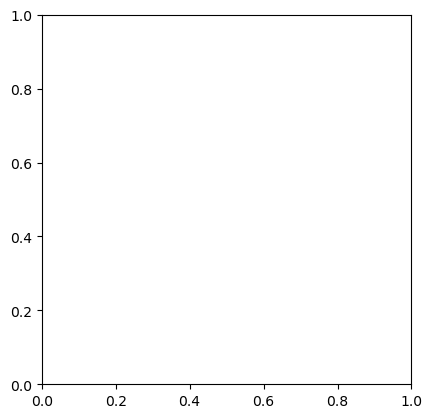

In [8]:
# matplotlib expect the image input in HxWxC but pyTorch reads the image as CxHxW
image, label = train_data[1]
plt.imshow(image)

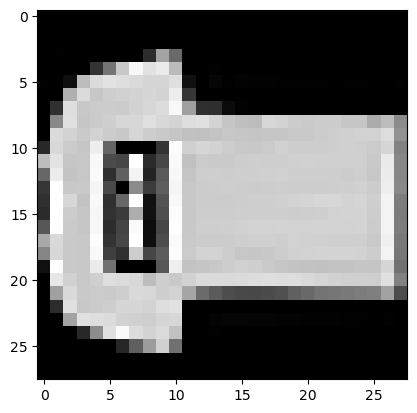

In [9]:
# right way to plot the image using matplotlib
plt.imshow(torch.permute(image,(2,1,0)), cmap="gray")
plt.show()

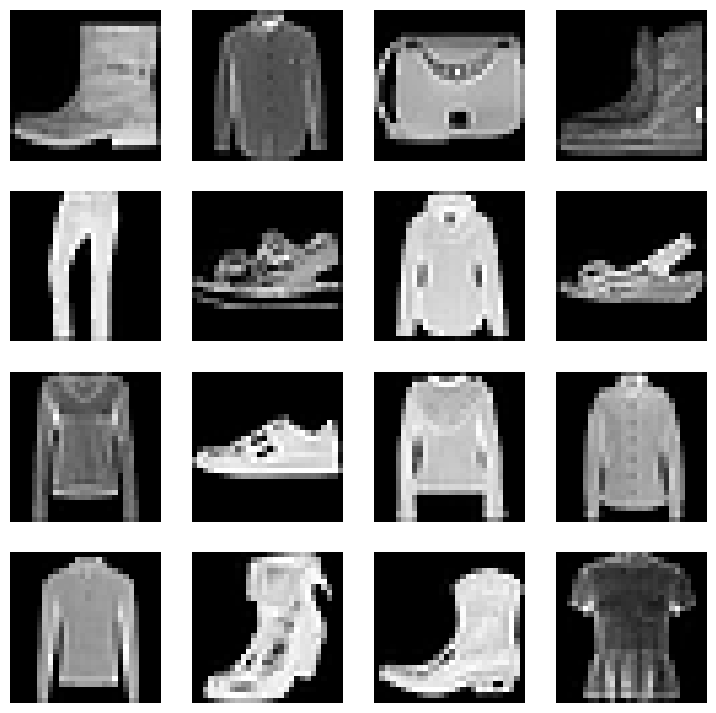

In [10]:
# plot more images at random order
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis(False)
    
    

In [11]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Prepare the Dataloader

**Why we need this**
* Right now, our data is in the form of PyTorch Datasets
* Dataloader turns our dataset into a Python iterable
* We want to turn our data into batches (mini-batches)
* **`Documentation`**: https://pytorch.org/docs/stable/data.html

In [12]:
from torch.utils.data import DataLoader

# setup the batch size
BATCH_SIZE = 32

# turn dataset into python iterable(batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)           # its good/easy of test data is not shuffled
train_dataloader, test_dataloader                     # instances of the dataloader

(<torch.utils.data.dataloader.DataLoader at 0x21c8f577340>,
 <torch.utils.data.dataloader.DataLoader at 0x21c8f576d40>)

In [13]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [14]:
# checkout how many batches of 32 size has been formed
print(f"Length of train_dataloaders: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloaders: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloaders: 1875 batches of 32
Length of test_dataloaders: 313 batches of 32


In [15]:
# checkout the first batch of the dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Visualize the Batch

Image Size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


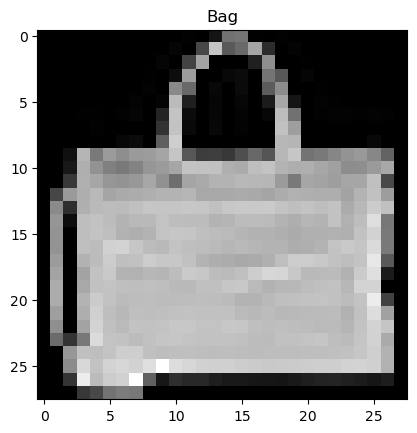

In [16]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
print(f"Image Size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


## Build a baseline Model

### understanding the concept of flatten layer
* In baseline model we are going to use the linear layer, which can't handle thet multidimensional data, hence we are converting into single vector

In [17]:
# create a flatten layer
flatten_model = nn.Flatten()              # nn.Flatten() can be used as model

# get sample from train data
sample = train_features_batch[0]

# Flatten the sample
flattened_sample = flatten_model(sample) # performing the forward pass

# print out result
print(f"Shape before flattening: {sample.shape}")
print(f"Shape after flattening: {flattened_sample.shape}")  # [color channel, height, width]

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [18]:
# build the model
class FashionMNIST(nn.Module):
    """Initialize the FashionMNIST muti-class classification model
    
    Args:
        input_features(int): Number of input features to the model
        output_features(int): Number of output features by the model
        hidden_units(int): Number of hidden units between the layers
    
    """
    def __init__(self,
                 input_features: int,
                 output_features: int,
                 hidden_units: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),      # in order to pass the data into linear layer
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            )
    
    # over-ride the forward method
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layers(x) 

modelbase = FashionMNIST(input_features=784,        # 28x28
                         output_features=10,        # ten output classes in datasets
                         hidden_units=10).to("cpu")   

modelbase

FashionMNIST(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
modelbase.state_dict()     # checking the model parameters

OrderedDict([('layers.1.weight',
              tensor([[-0.0042, -0.0145,  0.0237,  ..., -0.0319,  0.0206, -0.0111],
                      [-0.0272,  0.0052,  0.0173,  ...,  0.0023,  0.0029,  0.0097],
                      [ 0.0272, -0.0169,  0.0213,  ...,  0.0307, -0.0014, -0.0287],
                      ...,
                      [-0.0101, -0.0093,  0.0068,  ..., -0.0126, -0.0139, -0.0208],
                      [-0.0275,  0.0082,  0.0330,  ...,  0.0330,  0.0033,  0.0030],
                      [-0.0047, -0.0345,  0.0140,  ...,  0.0228,  0.0321, -0.0169]])),
             ('layers.1.bias',
              tensor([ 0.0152, -0.0084,  0.0227, -0.0054, -0.0284, -0.0354, -0.0013,  0.0105,
                      -0.0211,  0.0281])),
             ('layers.2.weight',
              tensor([[ 0.1500,  0.1907,  0.1457, -0.3050, -0.0580,  0.1643,  0.1565, -0.2877,
                       -0.1792,  0.2305],
                      [-0.2618,  0.2397, -0.0610,  0.0232,  0.1542,  0.0851, -0.2027,  0.1030,


### Downloading the python script from github using code
* **import accuracy helper function**

In [20]:
import requests
from pathlib import Path

# downloade helper functions from gitub repo
if Path("helper_funtions.py").is_file():
    print("helper_funtions.py already exits, skipping download.....")
else:
    print("Downloading helper_funtions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_funtions.py", "wb") as f:
        f.write(request.content)

helper_funtions.py already exits, skipping download.....


In [21]:
from helper_funtions import accuracy_fn

In [22]:
# setup the loss function
loss_fn = nn.CrossEntropyLoss()

# setup an optimizer
optimizer = torch.optim.SGD(params=modelbase.parameters(), 
                            lr = 0.1)

### Creating a function to time our experiments

In [23]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end:float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    
    total_time = end - start
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time

## Creating a training loop and training model on batches of data
**Steps:**
* Loop through batches
* Loop through training batches, perform training steps, calculate train loss per batch.
* Loop through testing batches, perform testing steps, calculate test loss per batch.
* Print out the stats

In [110]:
# import the tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start time
train_start_time_cpu = timer()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the no of epochs
epochs = 3

# create a training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-----")
    
    ## start the training mode
    train_loss = 0
    
    ## add loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        ## set the model on training mode
        modelbase.train()
        
        ## forward passs
        y_pred = modelbase(X)
        
        ## calculate the loss(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss               # accumulating the training loss
        
        ## zero-out the gradient
        optimizer.zero_grad()
        
        ## backpropagation
        loss.backward()
        
        ## optimizer step
        optimizer.step()
        
        ## print out stats per batch
        
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")
            
    # Divide the total train_loss by length of train dataloader (no of batches)
    train_loss = train_loss/ len(train_dataloader)         # average loss per epoch
    
    
    ## Testing loop 
    test_loss, test_acc = 0,0
    
    # set the model on eval() mode
    modelbase.eval()
    
    # turn on the inference mode
    with torch.inference_mode():
        # loop through images, labels in test_dataloader
        for X_test,y_test in test_dataloader:
            ## do the forward pass
            test_pred = modelbase(X_test)
            
            ## calculate the testing loss
            test_loss += loss_fn(test_pred, y_test)
            
            ## calculate the accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
            
         ## calculate the test loss average per batch
        test_loss = test_loss/ len(test_dataloader)
        
        ## calculate the test acc average per batch
        test_acc = test_acc/ len(test_dataloader)
    
    ## print out the training and testing stats
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc {test_acc:.4f}" )
        
                 
train_time_end_cpu = timer()
total_train_time_model_cpu= print_train_time(start=train_start_time_cpu, 
                       end=train_time_end_cpu, 
                       device=str(next(modelbase.parameters()).device))
total_train_time_model_cpu

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4319 | Test Loss: 0.4790, Test acc 83.4764
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4319 | Test Loss: 0.4790, Test acc 83.4764
Epoch: 3
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4319 | Test Loss: 0.4790, Test acc 83.4764
Train time on cpu : 28.477 seconds


28.477369099999123

## Make predication and  evaluate a model

In [42]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    
    loss, acc = 0, 0
    #set the model on eval mode
    model.eval()
     
    
    # turn on the inference mode
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # make predications-forward pass
            y_pred = model(X)
            
            # accumulate the test loss and accuracy per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))
        
        # Find the average loss
        loss = loss/len(data_loader)
        acc = acc/len(data_loader)
    
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}   

In [26]:
# calculate the modelbase results
modelbase_results = eval_model(model=modelbase, 
                               data_loader=test_dataloader, 
                               loss_fn=loss_fn, 
                               accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
modelbase_results

{'model_name': 'FashionMNIST',
 'model_loss': 0.47896072268486023,
 'model_acc': 83.47643769968052}

## Setup the device agnostic code

In [28]:
!nvidia-smi

Wed Oct  5 13:42:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P8     4W /  N/A |    282MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Build a Model using non-linearities and on GPU

In [30]:
class FashionMNISTV1(nn.Module):
    """Initialize the model FashionMNISTV1 for multi-class classification
    
    Args:
        input_features(int): Number of input features to the model
        output_features(int): Number of output features given by the model
        hidden_units(int): Number of hidden units between the layers
    """
    
    def __init__(self, 
                 input_shape:int, 
                 output_shape:int, 
                 hidden_units:int):
        super().__init__()
        
        ## define the model architecture
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=output_shape),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
            )
    
    ## over-ride the forward method
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layers(x)

# create an object of the model
modelv1 = FashionMNISTV1(input_shape=28*28,                # 28*28
                         output_shape=10,                  # 10 output classes
                         hidden_units=10).to(device)       # send the model to target device i.e "cuda" if available
print(modelv1)
print(f"\nModel Device:{next(modelv1.parameters()).device}")

FashionMNISTV1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

Model Device:cuda:0


In [31]:
# setup the loss function, optimizer
from helper_funtions import accuracy_fn

# loss funtion
loss_fn = nn.CrossEntropyLoss()       # measure how wrong our model predication is w.r.t to target
optimizer = torch.optim.SGD(params=modelv1.parameters(),  # optimise the model parameters using gradient method
                            lr = 0.1)

In [32]:
for batch , (X,y) in enumerate(train_dataloader):
    print(batch)
    print(len(X))
    print(len(y))
    break

0
32
32


## Functionizing training and testing loops

### Train_step():

In [33]:
device


'cuda'

In [34]:
# function for training loop - train_step()
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """performs a training with model trying to learn on data_loaders"""
    train_loss, train_acc = 0,0
    
    ## add a loop through the training batches of the train dataloaders
    for batch, (X,y) in enumerate(dataloader):
        ## set the model on train mode
        model.train()
        
        # put the data on the target device
        X, y = X.to(device), y.to(device)
        
        ## make predications using forward passs
        y_pred = model(X)
        
        ## calculate the loss per batch
        loss = loss_fn(y_pred,y)
        train_loss+= loss
        train_acc += accuracy_fn(y_true=y, 
                                 y_pred = y_pred.argmax(dim=1)) # argmax converting the raw logits --> predication labels
        
        ## zero-out the optimizer gradient
        optimizer.zero_grad()
        
        ## backpropagate the loss
        loss.backward()
        
        ## take optimisation step
        optimizer.step()
        
        ## print out how many samples we have pass through the optimization step
        if batch%400 == 0:
            print(f"No of samples passed through gradient optimization {batch*len(X)}/{len(dataloader.dataset)} sample...")   

        ## calculate the average loss per epoch 
    train_loss /= len(dataloader) # divide by no of bacthes 
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

### Test_step():

In [35]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module,
              accuracy_fn = accuracy_fn,
              device: torch.device= device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    
    # set the mode on eval mode
    model.eval()
    
    # turn on the inference mode
    with torch.inference_mode():
        # loop through dataloader
        for X,y in dataloader:
            # put the data on the target device
            X,y = X.to(device), y.to(device)
            
            # make predications --> do the forward pass
            test_pred = model(X)
            
            # calculate the loss/acc
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred = test_pred.argmax(dim=1)) # argmax to convert the raw logits into predication labels
        
        # adjust the loss and accuracy
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%\n")

### Use train_step() and test_step() to write the final training and testing loop

In [36]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
start_train_time_gpu = timer()

# set the epochs
epochs = 3

# create a final training and testing loop using train_step() and test_step() function
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    
    ## training step
    train_step(model=modelv1, 
               dataloader=train_dataloader, 
               loss_fn=nn.CrossEntropyLoss(), 
               optimizer=optimizer, 
               accuracy_fn=accuracy_fn, 
               device=device)
    
    ## test step
    test_step(model=modelv1, 
              dataloader=test_dataloader,
              loss_fn=nn.CrossEntropyLoss(),
              accuracy_fn=accuracy_fn,
              device=device)
end_train_time_gpu = timer()
total_train_time_gpu = print_train_time(start=start_train_time_gpu,
                                        end=end_train_time_gpu, 
                                        device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
-------
No of samples passed through gradient optimization 0/60000 sample...
No of samples passed through gradient optimization 12800/60000 sample...
No of samples passed through gradient optimization 25600/60000 sample...
No of samples passed through gradient optimization 38400/60000 sample...
No of samples passed through gradient optimization 51200/60000 sample...
Train Loss: 1.11456 | Train acc: 58.46%
Test Loss: 0.96320 | Test Acc: 63.40855%

Epoch: 2
-------
No of samples passed through gradient optimization 0/60000 sample...
No of samples passed through gradient optimization 12800/60000 sample...
No of samples passed through gradient optimization 25600/60000 sample...
No of samples passed through gradient optimization 38400/60000 sample...
No of samples passed through gradient optimization 51200/60000 sample...
Train Loss: 0.90905 | Train acc: 64.87%
Test Loss: 0.74544 | Test Acc: 72.61382%

Epoch: 3
-------
No of samples passed through gradient optimization 0/60000 samp

### Why my GPU compute time is slower than CPU compute time
**Reasons: Why is this ? **
1. It could be that overhead for copying the data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. Hardware has a better cpu in terms of compute capability than the GPU

**`Article to know more about GPU computing:`**: https://horace.io/brrr_intro.html

In [44]:
modelv1_results = eval_model(model=modelv1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
modelv1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.495336651802063,
 'model_acc': 82.67771565495208}

## Building a Convolutional Neural Network Model

**`Good Resource`**: https://poloclub.github.io/cnn-explainer/

In [95]:
# create a cnn model

class FashionMNISTV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer website"""
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super().__init__()
        
        # understood as feature extraction block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # understood as feature extraction block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # understood as classifier layer
        self.classfier = nn.Sequential(
            nn.Flatten(),                         # to flatten out the 2x2 matrix from previous layer into vector
            nn.Linear(in_features=hidden_units*7*7, # there is trick to calculate this
                      out_features=output_shape), 
        )
        
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        x = self.conv_block1(x);
#         print(x.shape)
        x = self.conv_block2(x);
#         print(x.shape)
        x = self.classfier(x)
#         print(x.shape)
        return x

In [96]:
torch.manual_seed(42)

modelv2 = FashionMNISTV2(input_shape=1,       # input color channels
                         output_shape=10,     # output classes
                         hidden_units=10).to(device)
modelv2

FashionMNISTV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### understanding working of conv2d layer

In [97]:
dummy_image_batch = torch.rand(size=(32,1,28,28))
dummy_image = dummy_image_batch[0]

print(dummy_image_batch.shape)
print(dummy_image.shape)

torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])


In [98]:
conv_2d_dummy = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3),stride=1, padding=0)
# do the forward pass through conv2d
result = conv_2d_dummy(dummy_image) # with unsqueeze output size is : torch.Size([1, 10, 62, 62])
result.shape

torch.Size([10, 26, 26])

### understanding of max2d layer

In [99]:
dummy_image.shape # printout shape of original shape

torch.Size([1, 28, 28])

In [100]:
# create dummy_max2dpool layer
max2d_dummy = nn.MaxPool2d(kernel_size=2)

# do forward pass
maxpool_output = max2d_dummy(dummy_image)
print(maxpool_output.shape)

torch.Size([1, 14, 14])


### Here's the trick to understand how to calculate the output_features shape in the final classifier layer

In [101]:
modelv2(dummy_image.unsqueeze(0).to(device))

"""
Look at the error and the shapes that we have printed after each forward layer through conv block
---
torch.Size([1, 10, 62, 62])
"""

'\nLook at the error and the shapes that we have printed after each forward layer through conv block\n---\ntorch.Size([1, 10, 62, 62])\n'

## Train the CNN Model

In [102]:
## setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=modelv2.parameters(),
                            lr = 0.01)

In [103]:
## setup the training and testing loop using train_step() and test_step() functions
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Measure time
from timeit import default_timer as timer
start_train_time_modelv2 = timer()

## Train and Test loop
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    train_step(model=modelv2,
               dataloader=train_dataloader,
               loss_fn=loss_fn, 
               optimizer=optimizer,
               accuracy_fn=accuracy_fn, 
               device=device)
    
    test_step(model=modelv2, 
              dataloader=test_dataloader, 
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
end_train_time_modelv2 = timer()
total_train_time_modelv2_gpu = print_train_time(start=start_train_time_modelv2, 
                                                end=end_train_time_modelv2, 
                                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
No of samples passed through gradient optimization 0/60000 sample...
No of samples passed through gradient optimization 12800/60000 sample...
No of samples passed through gradient optimization 25600/60000 sample...
No of samples passed through gradient optimization 38400/60000 sample...
No of samples passed through gradient optimization 51200/60000 sample...
Train Loss: 1.03787 | Train acc: 62.34%
Test Loss: 0.62510 | Test Acc: 76.86701%

Epoch: 1
----
No of samples passed through gradient optimization 0/60000 sample...
No of samples passed through gradient optimization 12800/60000 sample...
No of samples passed through gradient optimization 25600/60000 sample...
No of samples passed through gradient optimization 38400/60000 sample...
No of samples passed through gradient optimization 51200/60000 sample...
Train Loss: 0.54918 | Train acc: 80.01%
Test Loss: 0.49867 | Test Acc: 81.53954%

Epoch: 2
----
No of samples passed through gradient optimization 0/60000 sample...
No 

In [104]:
# modelv2 results
modelv2_results = eval_model(model=modelv2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             )

  0%|          | 0/313 [00:00<?, ?it/s]

In [105]:
modelv2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.4400119483470917,
 'model_acc': 84.27515974440895}

## Compare the different models results

In [109]:
import pandas as pd

compare_model_results = pd.DataFrame([modelbase_results, modelv1_results, modelv2_results])
compare_model_results

,model_name,model_loss,model_acc
0,FashionMNIST,0.478961,83.476438
1,FashionMNISTV1,0.495337,82.677716
2,FashionMNISTV2,0.440012,84.275160


In [111]:
## add training time to dataframes
compare_model_results["training_time"] = [total_train_time_model_cpu, total_train_time_gpu, total_train_time_modelv2_gpu]

In [112]:
compare_model_results

,model_name,model_loss,model_acc,training_time
0,FashionMNIST,0.478961,83.476438,28.477369
1,FashionMNISTV1,0.495337,82.677716,38.901632
2,FashionMNISTV2,0.440012,84.275160,107.443841


Text(0, 0.5, 'model')

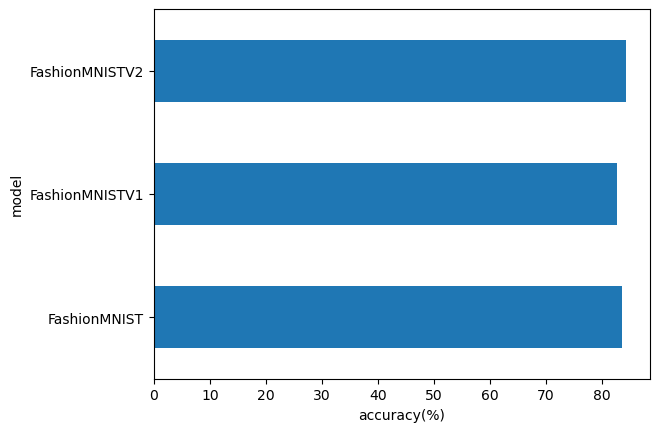

In [113]:
## Visualize our model results in bar chart
compare_model_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

## Make and evaluate random predications with best model

In [123]:
def make_predications(model: torch.nn.Module,
                      data: list,
                      device: torch.device = device):
    pred_probs = []
    # put the model on target device
    model.to(device)
    
    # set the model on eval mode
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # add the batch dimension to the sample and put it on target device
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # do the forward pass
            pred_logit = model(sample)
            
            # get the predication probablities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # put the pred_probs on cpu as matplotlib works data available on cpu
            pred_probs.append(pred_prob.cpu())
            
    # stack the pred_probs to turn the list into a tensor
    return torch.stack(pred_probs)        

Text(0.5, 1.0, 'Sandal')

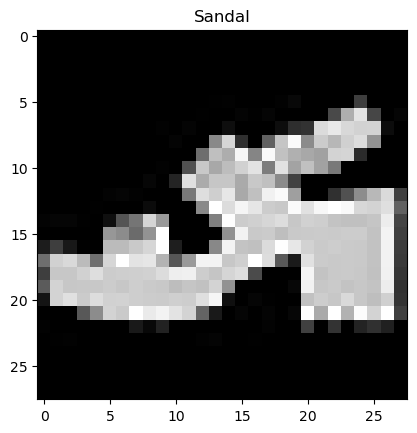

In [124]:
## randomly sample the 9 samples form the test data
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
#view the test sample
test_samples[0].shape
plt.imshow(torch.permute(test_samples[0],(1,2,0)), cmap="gray")
plt.title(class_names[test_labels[0]])

In [129]:
## Make predications
pred_probs = make_predications(model=modelv2,
                               data=test_samples,
                               device = device)

## convert the pred_probs into predication labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes                            

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [128]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

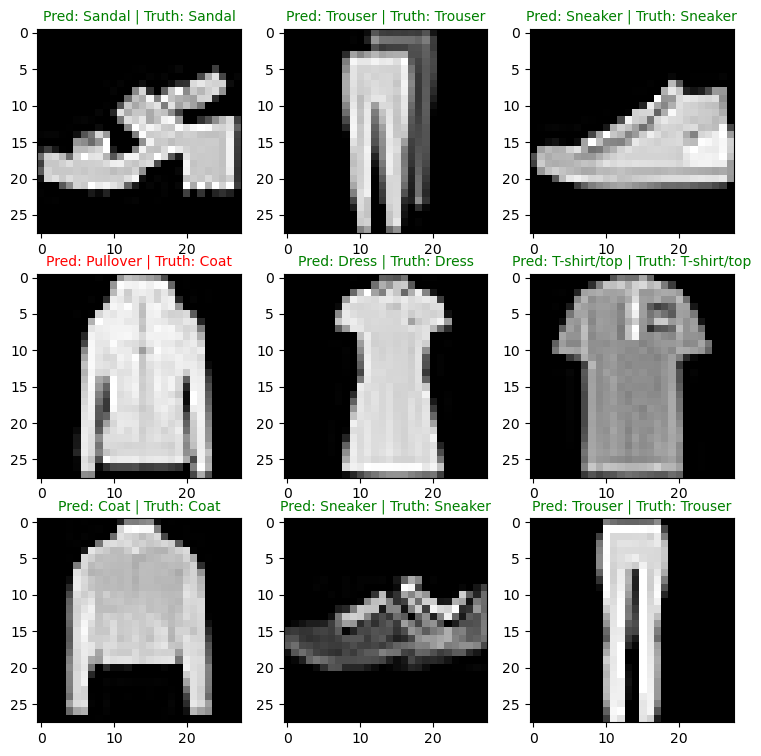

In [130]:
# plot the test images with true label and predication label
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # create subplot
    plt.subplot(nrows,ncols,i+1)  # +1 bcz can't start from zero
    
    # plot the test image
    plt.imshow(sample.squeeze(), cmap="gray") # squeeze to remove the color channels, but when we have 3 color channls use permute
    
    # find the predication label in text form
    pred_label = class_names[pred_classes[i]]
    
    # get the truth label in text form
    truth_label = class_names[test_labels[i]]
    
    # create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # change the color if pred_label != truth_label
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    
    

In [134]:
# save the model

from pathlib import Path

# create model dir path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)

# create a model save
MODEL_NAME = "02_FashionMNIST_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [137]:
MODEL_SAVE_PATH

WindowsPath('models/02_FashionMNIST_CNN.pth')

In [138]:
# save the model parameters
print(f"Saving model parameters: {MODEL_SAVE_PATH}")
torch.save(obj=modelv2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model parameters: models\02_FashionMNIST_CNN.pth


## Load the saved model parameters

In [140]:
# create a instance of model

loaded_modelv2 = FashionMNISTV2(input_shape=1,
                                output_shape=10,
                                hidden_units=10)

# load the saved state dict
loaded_modelv2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# send the model to target device
loaded_modelv2.to(device)

FashionMNISTV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)